### SV calling from pairwise cigar strings - all pairs, all chroms

This notebook generates plots for SVs derived from centrolign pairwise cigar strings. 

In [ ]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## Read in input data 

# csv formatted as clade, path_to_SV_beds 
input_csv="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/11172025_clade_chr_sv_beds.csv"

# prefix for output plots
plot_prefix="/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr8/test/plots/"

# pairwise distance file 
pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"

In [5]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, chr, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["chr"] = chr
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds:
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file","chr"])

In [6]:
### For all clades in provided input csv, read SVs into dataframe and merge 

clade_info = pd.read_csv(input_csv)
if not {"clade", "chr","path_to_SV_beds"}.issubset(clade_info.columns):
    raise ValueError("Input CSV must contain columns: 'clade' and 'chr' and 'path_to_SV_beds'")

#clade_info_subset= clade_info.head(3)

all_data = []

for _, row in clade_info.iterrows():
    clade = str(row["clade"])
    chr = str(row["chr"])
    bed_folder = str(row["path_to_SV_beds"])
    df = read_sv_bed_files(clade, chr, bed_folder)
    if not df.empty:
        all_data.append(df)

if all_data:
    merged_df = pd.concat(all_data, ignore_index=True)

    #print("=== Head of merged DataFrame ===")
    #(merged_df.head(), "\n")

    # Print count of rows per clade
    print("=== Record count per clade ===")
    print(merged_df["clade"].value_counts())

Found 10440 SV bed files for clade 'chr5_subgroup0'
Found 18528 SV bed files for clade 'chr5_subgroup1'
Found 17205 SV bed files for clade 'chr12_subgroup0'
Found 17391 SV bed files for clade 'chr12_subgroup1'
Found 18336 SV bed files for clade 'chr8_subgroup0'
Found 12403 SV bed files for clade 'chr8_subgroup1'
Found 9591 SV bed files for clade 'chr17'
Found 6786 SV bed files for clade 'chr18'
Found 18721 SV bed files for clade 'chr6'
Found 7750 SV bed files for clade 'chr4'
Found 9453 SV bed files for clade 'chr3'
Found 19110 SV bed files for clade 'chr7_subgroup0'
Found 5050 SV bed files for clade 'chr7_subgroup1'
Found 16110 SV bed files for clade 'chr22_subgroup0'
Found 17391 SV bed files for clade 'chr22_subgroup1'
Found 11026 SV bed files for clade 'chr20_subgroupB'
Found 16110 SV bed files for clade 'chr20_subgroupD'
Found 12246 SV bed files for clade 'chr1_subgroupB'
Found 988 SV bed files for clade 'chrY'
Found 22366 SV bed files for clade 'chr19_subgroup0'
Found 5050 SV bed 

In [7]:
print(merged_df.columns)

Index(['sample1', 'start1', 'end1', 'sample2', 'start2', 'end2', 'type',
       'diff', 'clade', 'chr', 'source_file', 'length'],
      dtype='object')


In [8]:
import pandas as pd
import numpy as np
import glob
import os

# Directory containing CSV files
pairwise_dist_dir = pairwise_dist  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None, names=['sample1', 'sample2', 'pairwise_dist'])
    df["chr"] = chr_val

    all_dfs.append(df)

# Combine into one dataframe
dist_df = pd.concat(all_dfs, ignore_index=True)

# Sort sample pairs so ordering doesn't matter
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_sv_sorted = merged_df.copy()
df_sv_sorted[['sample1', 'sample2']] = np.sort(df_sv_sorted[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df_sv_sorted = df_sv_sorted.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df_sv_sorted.head()


,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844


In [9]:
# Create a sample_pair identifier
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]

/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/3019868906.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


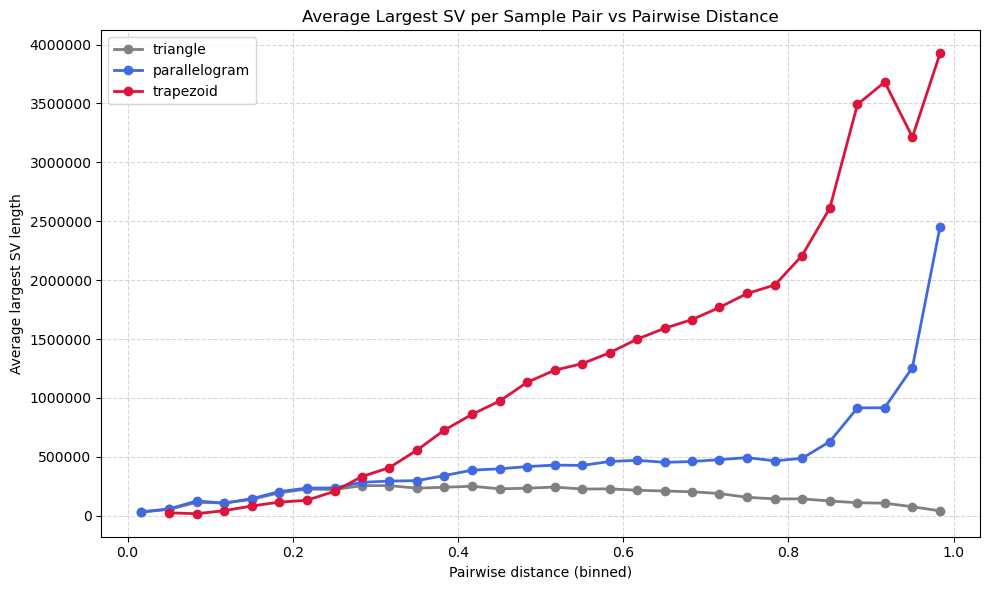

In [11]:
### All chromosomes combined 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Ensure sample_pair is defined
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]


conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}


# -------------------------------------------------------
# 1. Define bins over pairwise distance
# -------------------------------------------------------
n_bins = 30
df_sv_sorted['pairwise_dist'] = df_sv_sorted['pairwise_dist'].astype(float)
bins = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)


# -------------------------------------------------------
# 2. Function: largest SV per sample pair
# -------------------------------------------------------
def get_largest_sv(subset):
    largest = (
        subset.sort_values("length", ascending=False)
              .groupby("sample_pair", as_index=False)
              .first()   # row with maximum 'length'
    )
    return largest


# -------------------------------------------------------
# 3. Compute mean largest-SV per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():
    subset = df_sv_sorted[mask].copy()

    # collapse to largest SV per sample_pair
    largest = get_largest_sv(subset)

    # bin distances for these pairs
    largest["dist_bin"] = pd.cut(largest["pairwise_dist"], bins=bins.cat.categories)

    # compute mean length per bin
    stats = (
        largest.groupby("dist_bin")["length"]
               .mean()
               .reset_index(name="mean_length")
    )
    stats["condition"] = label
    plot_df.append(stats)

plot_df = pd.concat(plot_df, ignore_index=True)


# -------------------------------------------------------
# 4. Plot
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # x-axis = midpoint of each distance bin
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["mean_length"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("Average largest SV length")
ax.set_title("Average Largest SV per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()

/data/tmp/ipykernel_2377993/3947507109.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/3947507109.py:45: FutureWarning: The def

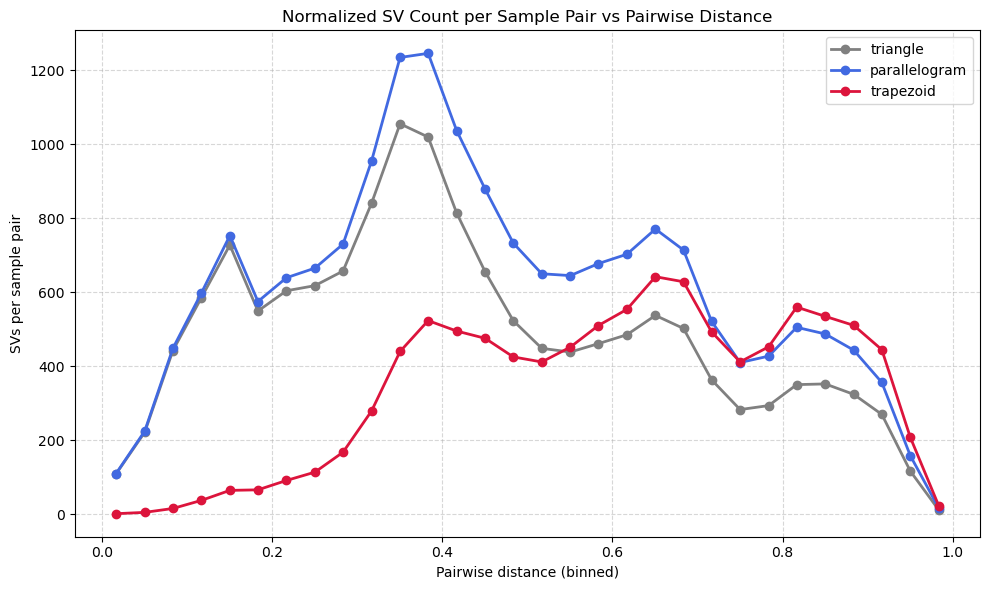

In [12]:
# All chromosomes combined 
from matplotlib.ticker import ScalarFormatter

conditions = {
    "triangle":  (df_sv_sorted["diff"] == -1),
    "parallelogram": (df_sv_sorted["diff"] < 0.1),
    "trapezoid": (df_sv_sorted["diff"] > 0.1)
}

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -------------------------------------------------------
# 1. Define global distance bins
# -------------------------------------------------------
n_bins = 30
df_sv_sorted["dist_bin"] = pd.cut(df_sv_sorted["pairwise_dist"], bins=n_bins)

# -------------------------------------------------------
# 2. Count how many sample pairs occur in each bin
# -------------------------------------------------------
# One row per sample-pair for correct weighting
pairs = df_sv_sorted.groupby("sample_pair", as_index=False)["pairwise_dist"].first()
pairs["dist_bin"] = pd.cut(pairs["pairwise_dist"], bins=df_sv_sorted["dist_bin"].cat.categories)

sample_pair_counts = (
    pairs.groupby("dist_bin")
         .size()
         .reset_index(name="num_pairs_in_bin")
)

# -------------------------------------------------------
# 3. Count SVs per bin per condition
# -------------------------------------------------------
plot_df = []

for label, mask in conditions.items():

    subset = df_sv_sorted[mask]

    sv_counts = (
        subset.groupby("dist_bin")
              .size()
              .reset_index(name="sv_count")
    )

    # merge in the number of sample pairs in that bin
    merged = sv_counts.merge(sample_pair_counts, on="dist_bin", how="left")

    # Normalize:
    merged["svs_per_pair"] = merged["sv_count"] / merged["num_pairs_in_bin"]

    merged["condition"] = label
    plot_df.append(merged)

plot_df = pd.concat(plot_df, ignore_index=True)

# -------------------------------------------------------
# 4. Plot normalized SV counts
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for label in conditions.keys():
    df_c = plot_df[plot_df["condition"] == label].copy()

    # Convert bins to midpoints for plotting
    df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

    ax.plot(
        df_c["midpoint"],
        df_c["svs_per_pair"],
        marker="o",
        color=colors[label],
        linewidth=2,
        label=label
    )

ax.set_xlabel("Pairwise distance (binned)")
ax.set_ylabel("SVs per sample pair")
ax.set_title("Normalized SV Count per Sample Pair vs Pairwise Distance")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()


yfmt = ScalarFormatter(useOffset=False)
yfmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.tight_layout()
plt.show()

Processing chromosome: chr1


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

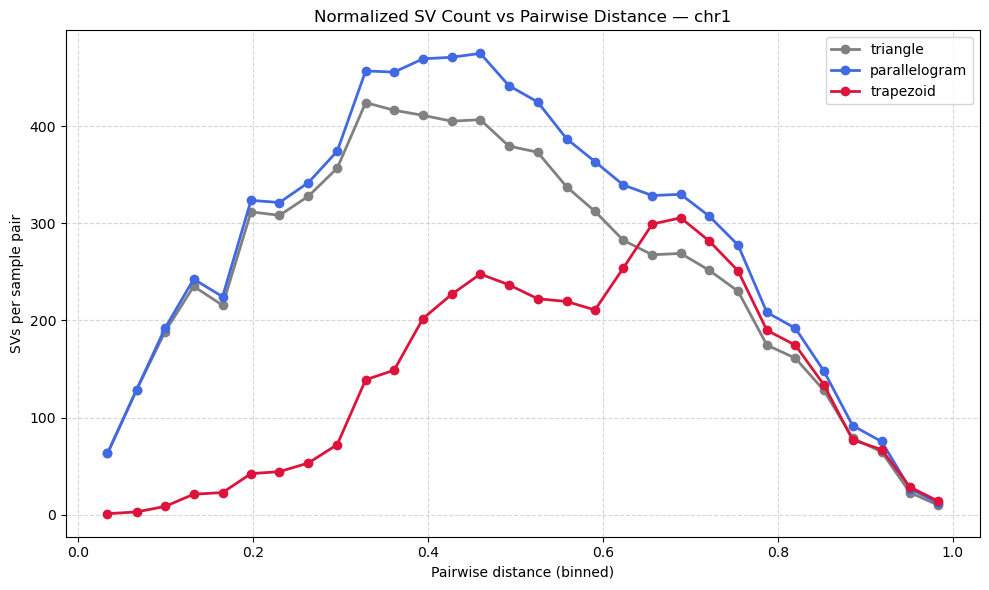

Processing chromosome: chr10


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

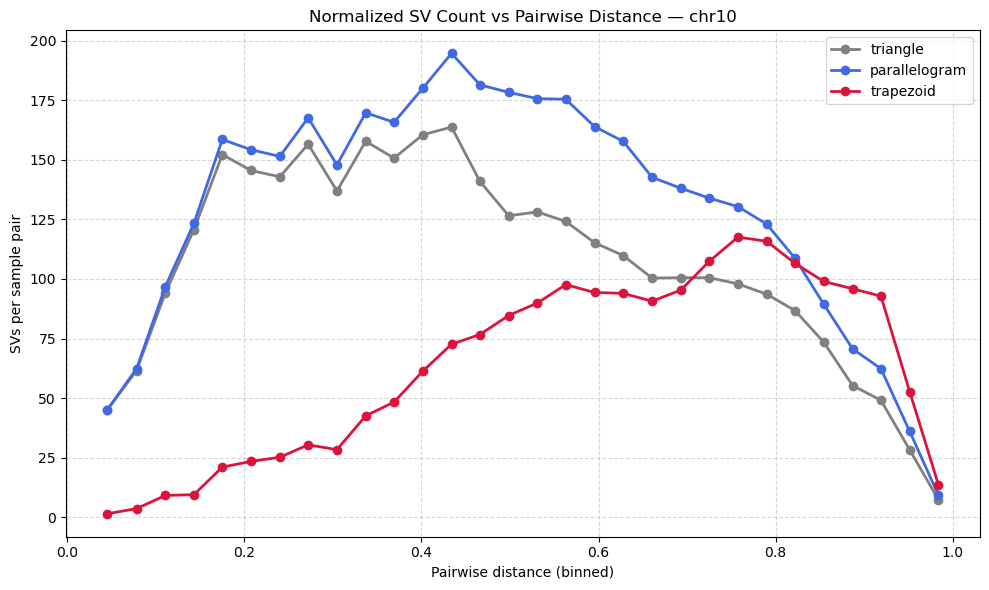

Processing chromosome: chr11


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

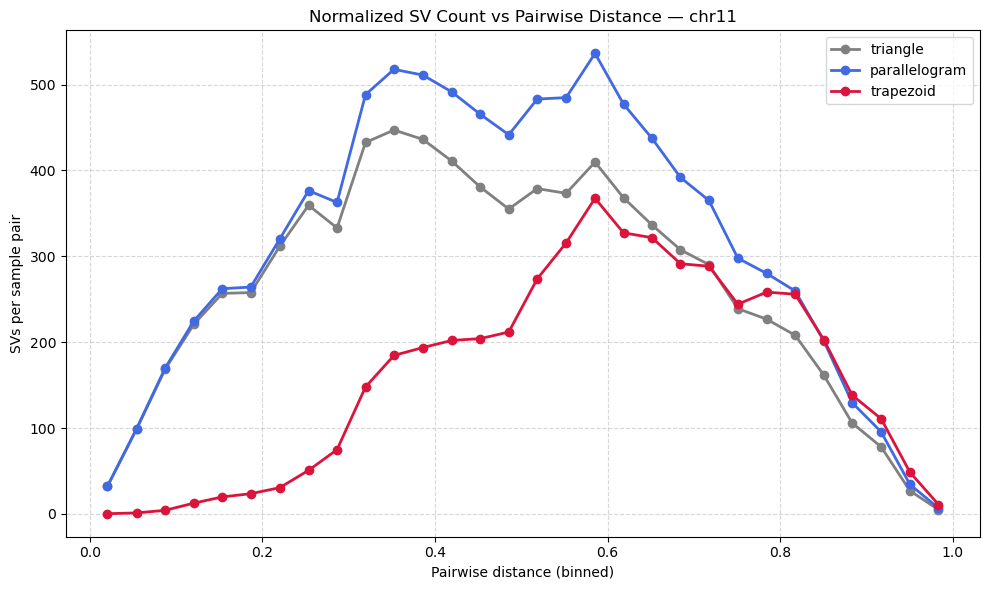

Processing chromosome: chr12


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

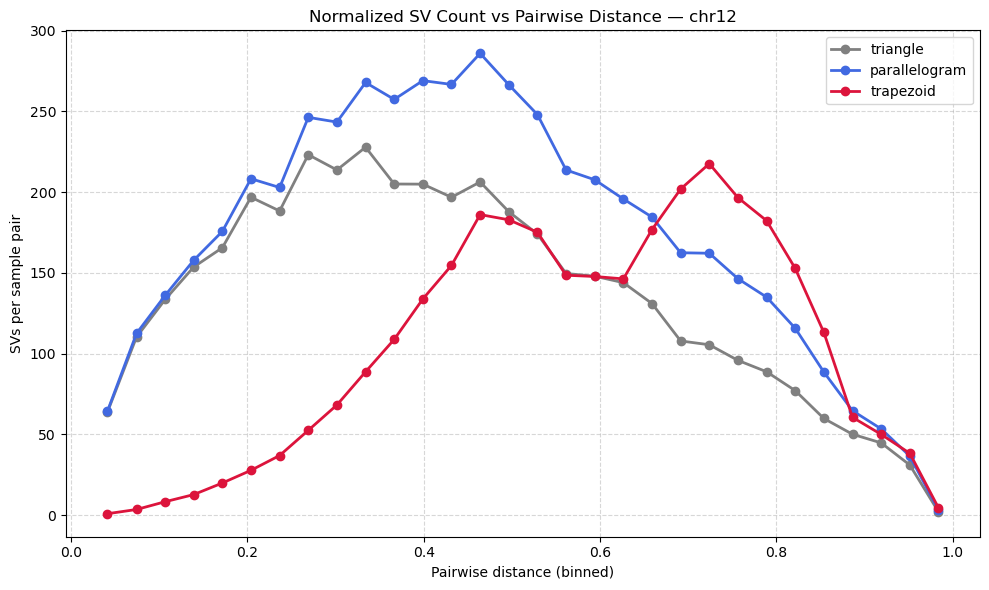

Processing chromosome: chr17


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

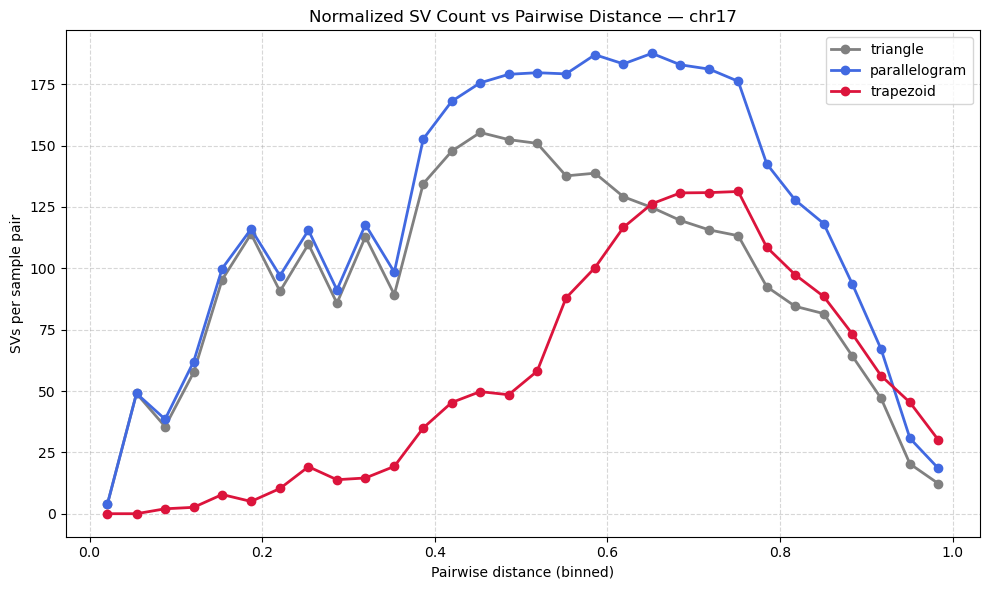

Processing chromosome: chr18


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

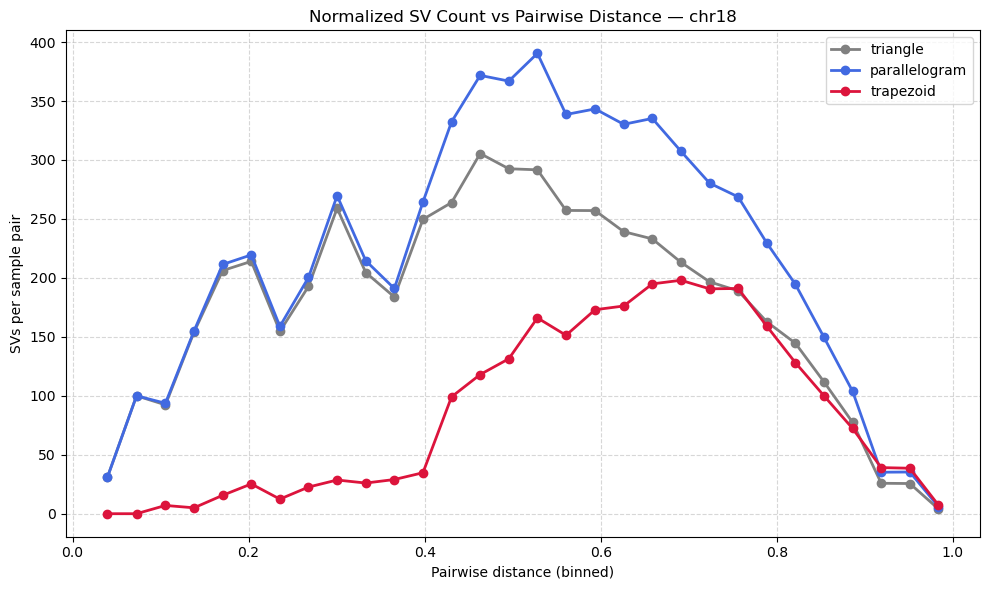

Processing chromosome: chr19


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

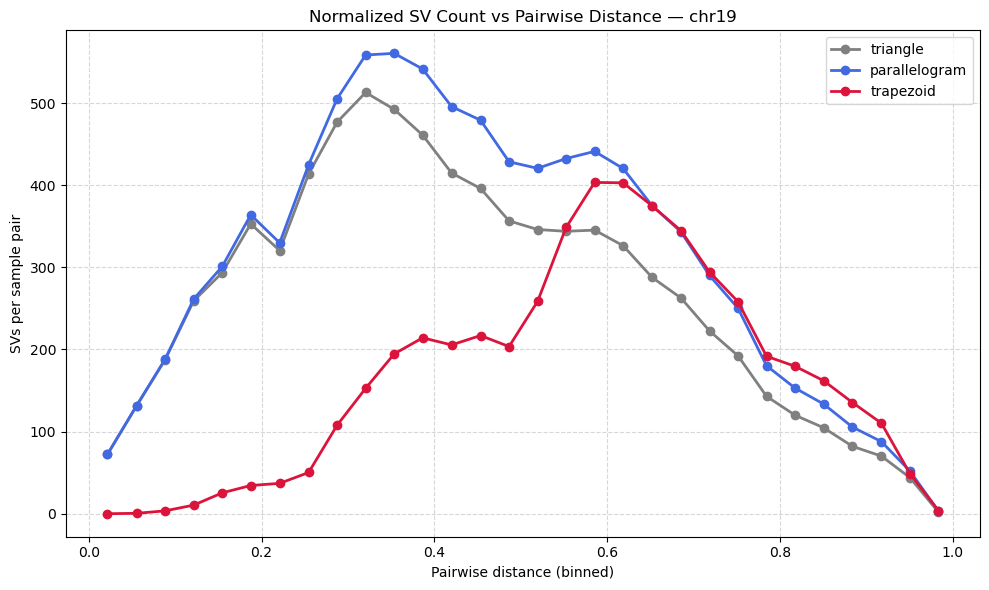

Processing chromosome: chr20


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

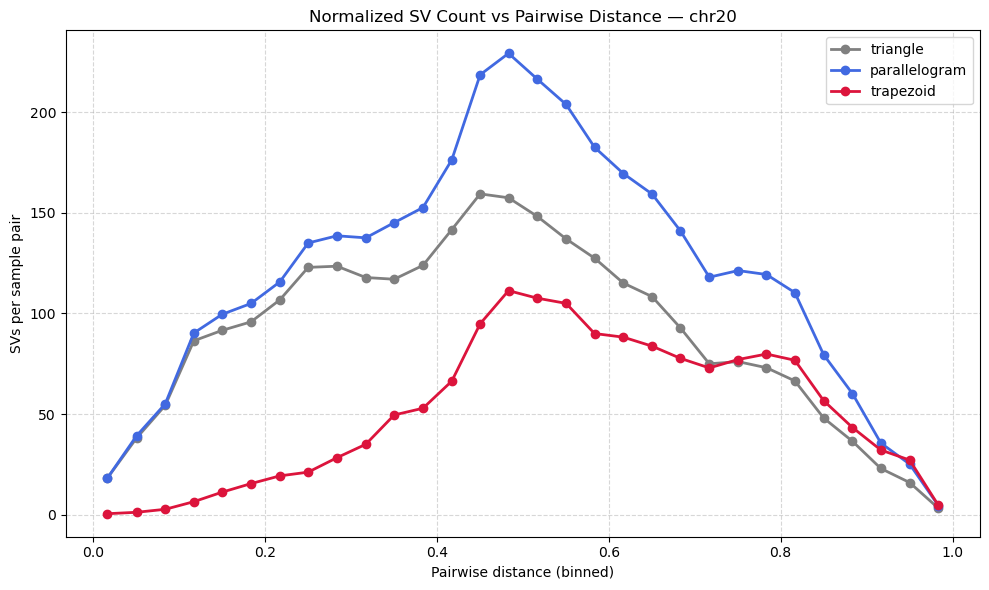

Processing chromosome: chr21


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

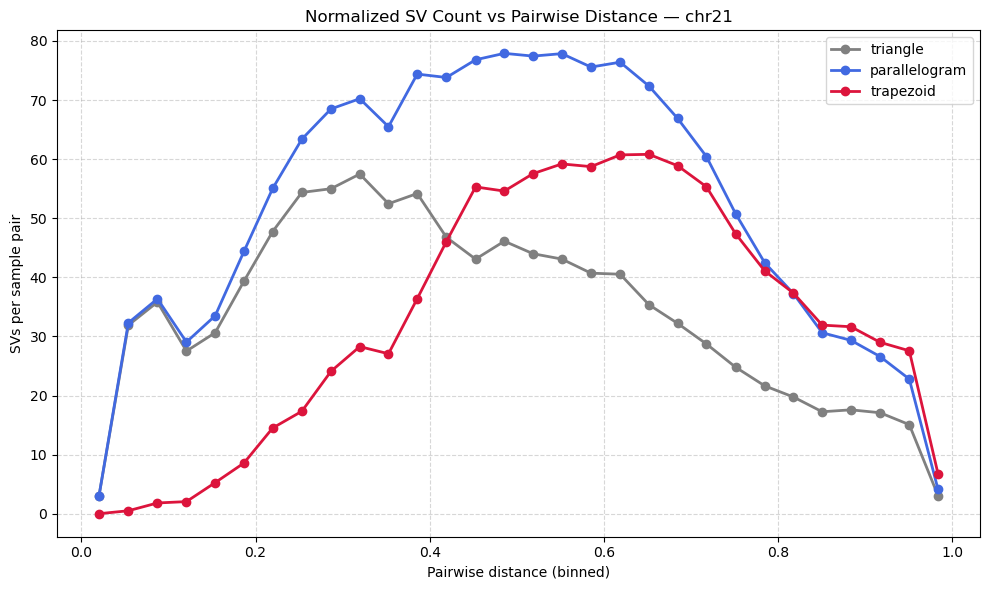

Processing chromosome: chr22


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

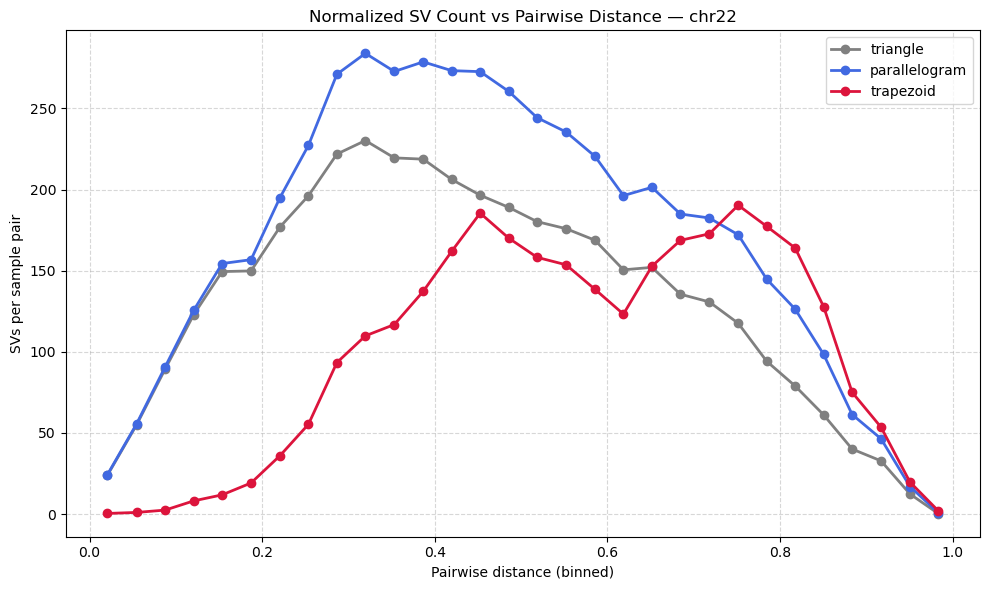

Processing chromosome: chr3


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

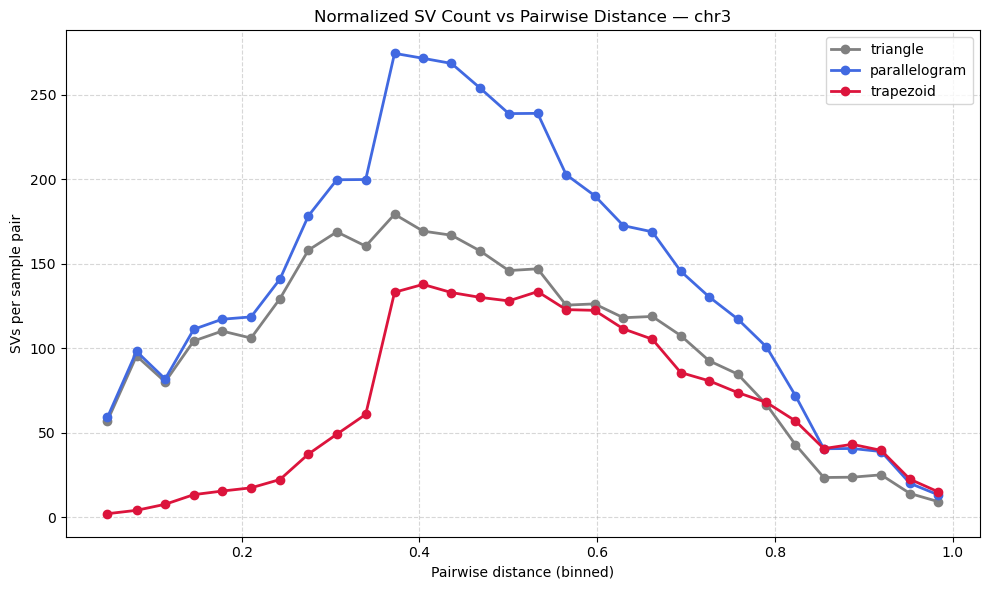

Processing chromosome: chr4


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

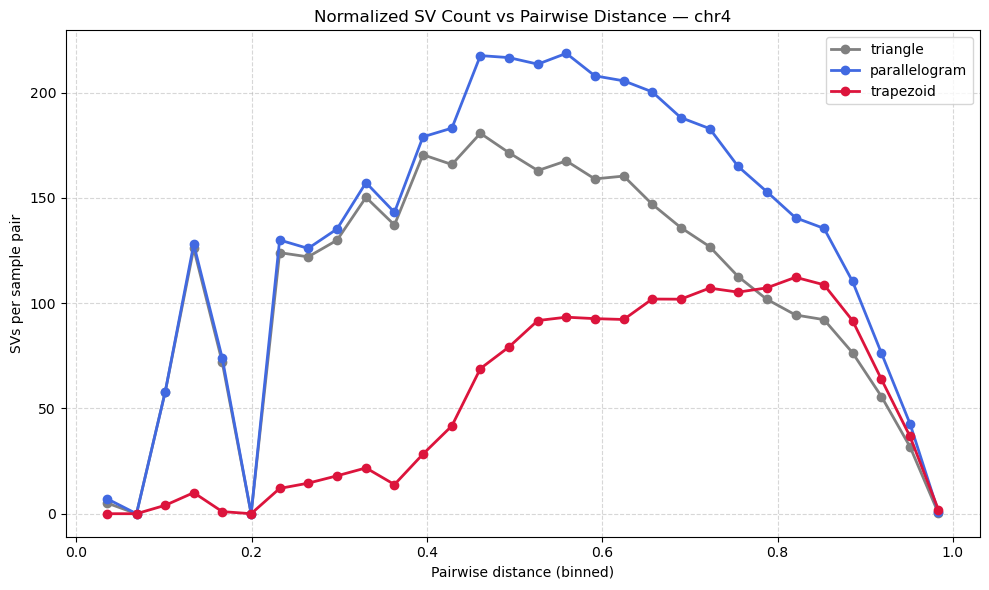

Processing chromosome: chr5


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

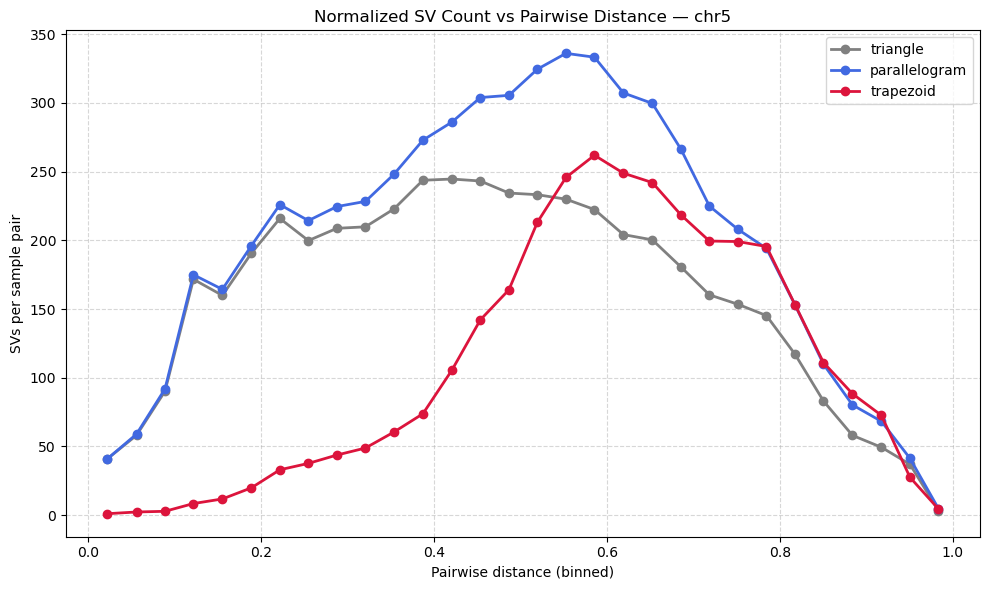

Processing chromosome: chr6


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

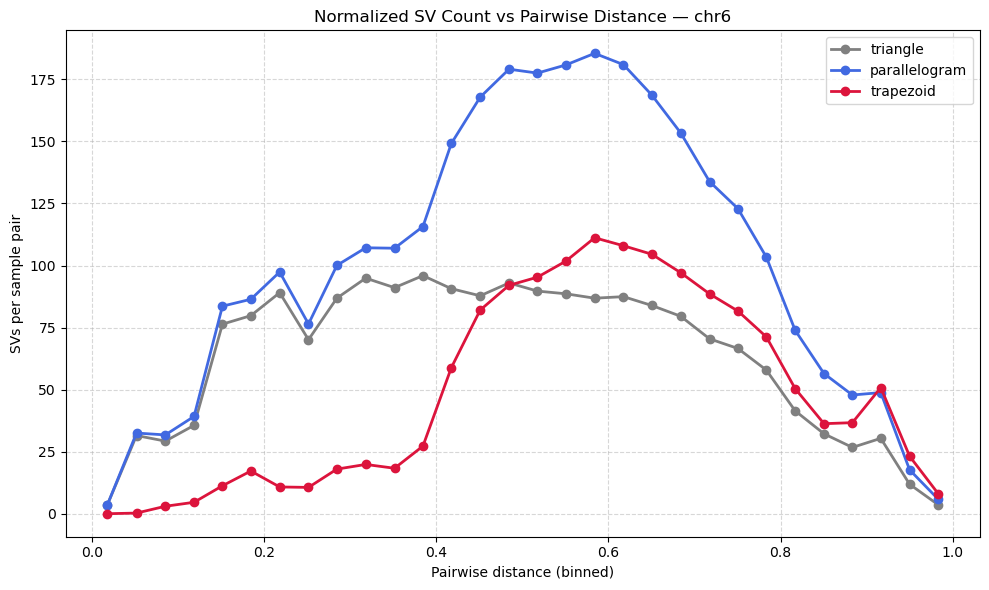

Processing chromosome: chr7


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

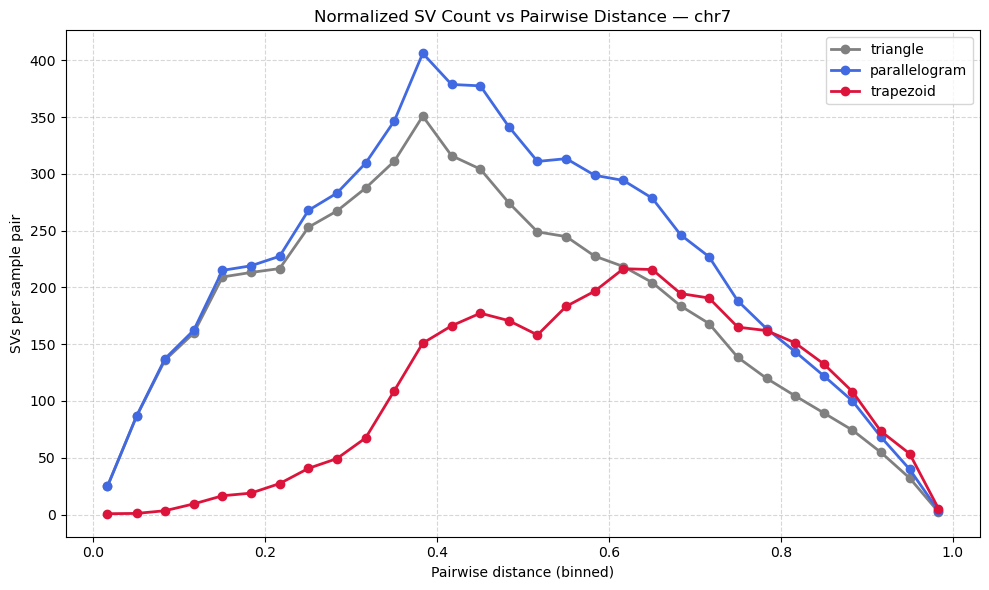

Processing chromosome: chr8


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

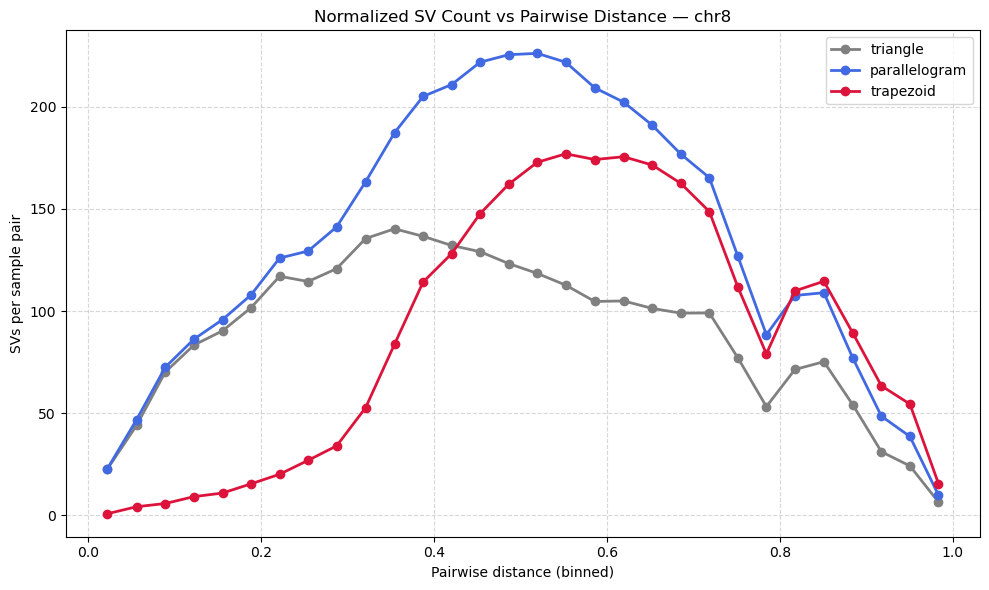

Processing chromosome: chr9


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

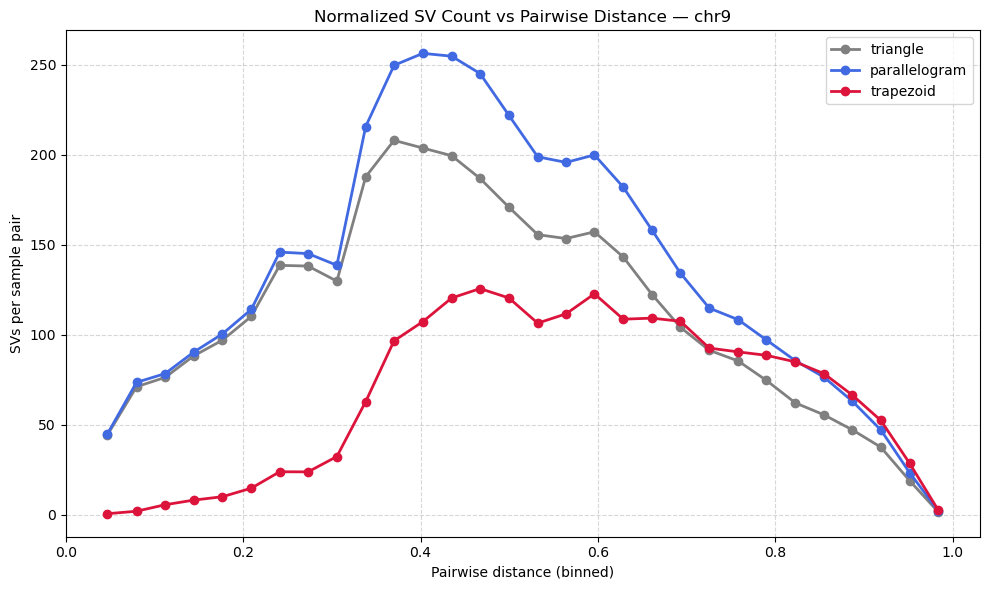

Processing chromosome: chrY


/data/tmp/ipykernel_2377993/1997374393.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby("dist_bin")
/data/tmp/ipykernel_2377993/1997374393.py:64: FutureWarning: The def

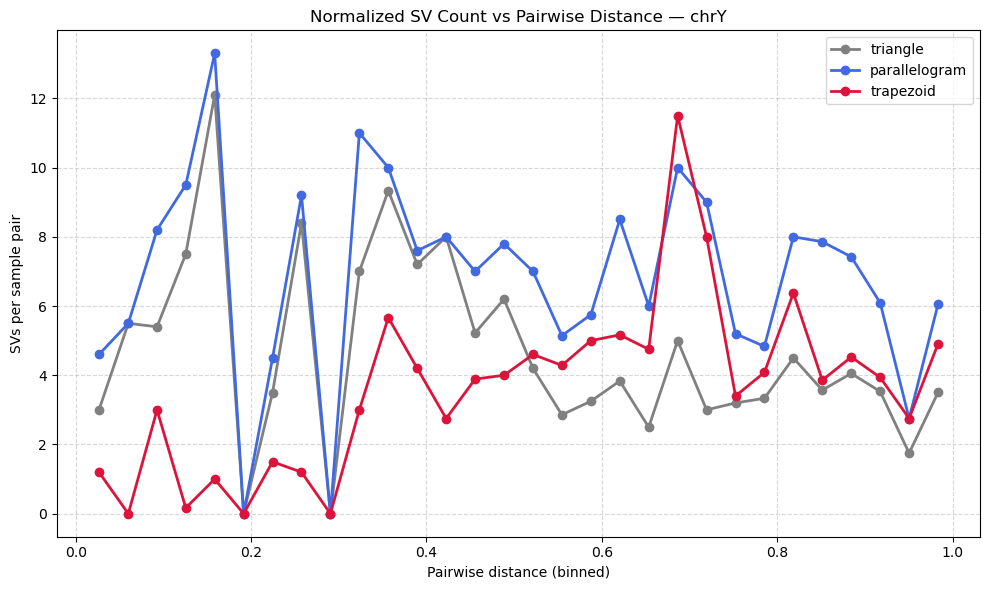

In [13]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import numpy as np

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -----------------------------------------
# Loop over chromosomes
# -----------------------------------------
for chr_val in sorted(df_sv_sorted["chr"].unique()):

    print(f"Processing chromosome: {chr_val}")

    df_chr = df_sv_sorted[df_sv_sorted["chr"] == chr_val].copy()

    # -----------------------------------------
    # 1. Clean distance column and create bins
    # -----------------------------------------
    n_bins = 30

    df_chr["pairwise_dist"] = pd.to_numeric(df_chr["pairwise_dist"], errors="coerce")
    df_chr = df_chr.dropna(subset=["pairwise_dist"])

    df_chr["dist_bin"] = pd.cut(df_chr["pairwise_dist"], bins=n_bins)

    # -----------------------------------------
    # Condition masks must be computed on df_chr
    # -----------------------------------------
    conditions = {
        "triangle": (df_chr["diff"] == -1),
        "parallelogram": (df_chr["diff"] < 0.1),
        "trapezoid": (df_chr["diff"] > 0.1)
    }

    # -----------------------------------------
    # 2. Count unique sample pairs for weighting
    # -----------------------------------------
    pairs = df_chr.groupby("sample_pair", as_index=False)["pairwise_dist"].first()
    pairs["pairwise_dist"] = pd.to_numeric(pairs["pairwise_dist"], errors="coerce")
    pairs = pairs.dropna(subset=["pairwise_dist"])

    pairs["dist_bin"] = pd.cut(pairs["pairwise_dist"], bins=df_chr["dist_bin"].cat.categories)

    sample_pair_counts = (
        pairs.groupby("dist_bin")
             .size()
             .reset_index(name="num_pairs_in_bin")
    )

    # -----------------------------------------
    # 3. Count SVs per bin per condition
    # -----------------------------------------
    plot_df = []

    for label, mask in conditions.items():

        subset = df_chr[mask]

        sv_counts = (
            subset.groupby("dist_bin")
                  .size()
                  .reset_index(name="sv_count")
        )

        merged = sv_counts.merge(sample_pair_counts, on="dist_bin", how="left")
        merged["num_pairs_in_bin"] = merged["num_pairs_in_bin"].fillna(0)

        merged["svs_per_pair"] = np.where(
            merged["num_pairs_in_bin"] > 0,
            merged["sv_count"] / merged["num_pairs_in_bin"],
            0
        )

        merged["condition"] = label
        plot_df.append(merged)

    plot_df = pd.concat(plot_df, ignore_index=True)

    # -----------------------------------------
    # 4. Plot — one figure per chromosome
    # -----------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    for label in conditions.keys():
        df_c = plot_df[plot_df["condition"] == label].copy()
        if df_c.empty:
            continue

        df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

        ax.plot(
            df_c["midpoint"],
            df_c["svs_per_pair"],
            marker="o",
            color=colors[label],
            linewidth=2,
            label=label
        )

    ax.set_xlabel("Pairwise distance (binned)")
    ax.set_ylabel("SVs per sample pair")
    ax.set_title(f"Normalized SV Count vs Pairwise Distance — {chr_val}")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()


Processing chromosome: chr1


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


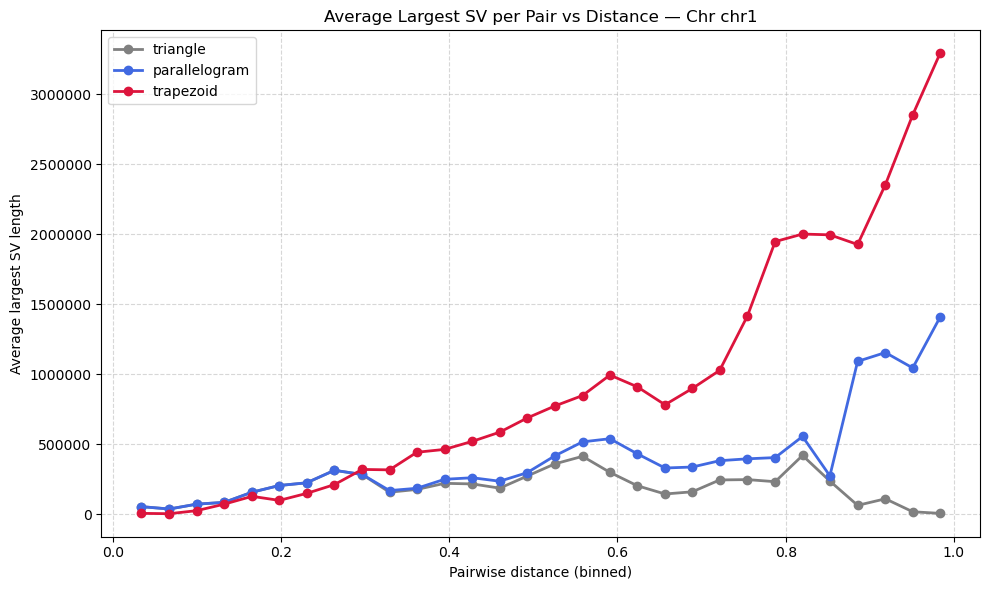

Processing chromosome: chr10


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


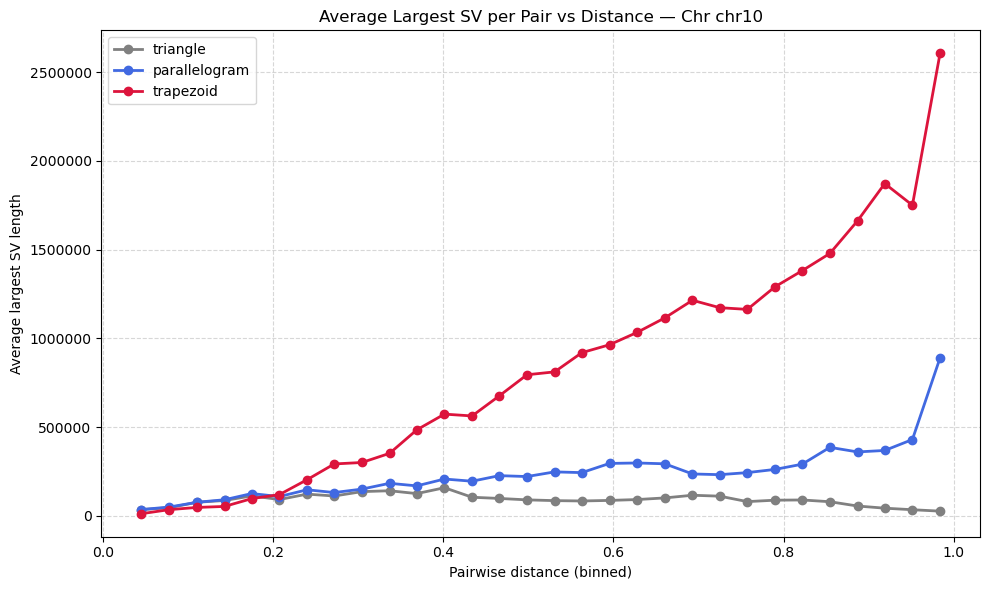

Processing chromosome: chr11


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


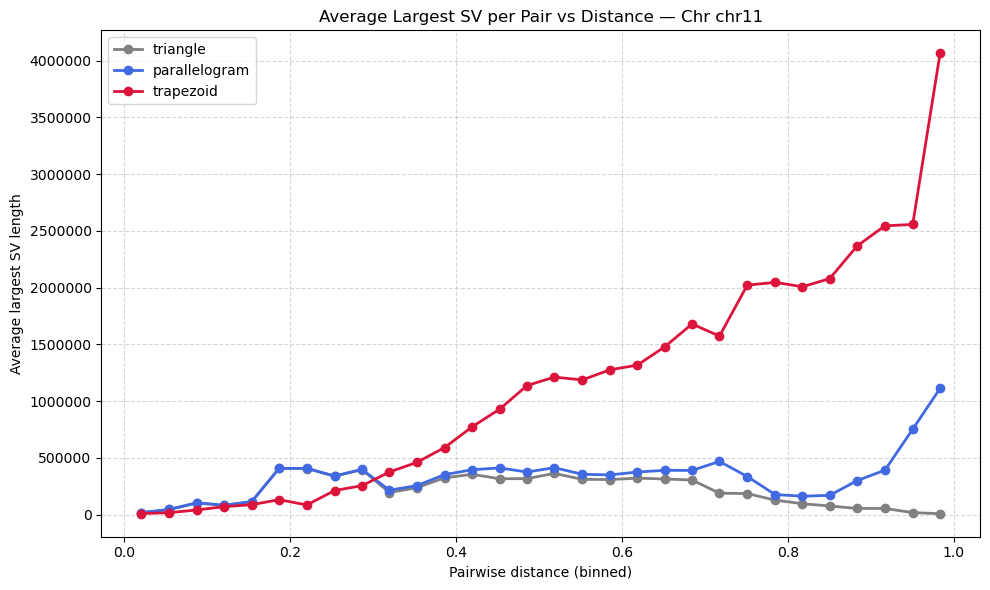

Processing chromosome: chr12


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


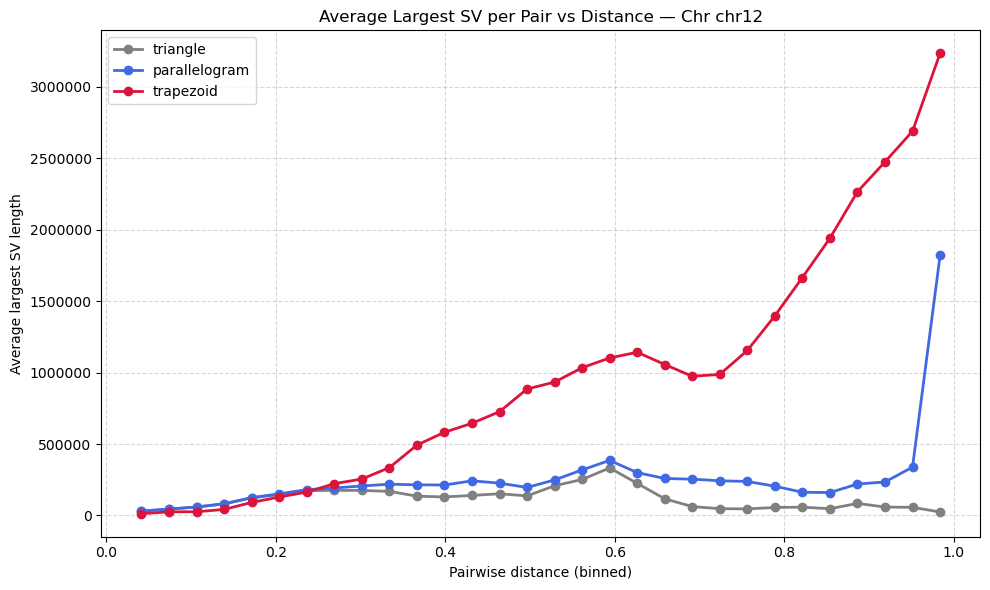

Processing chromosome: chr17


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


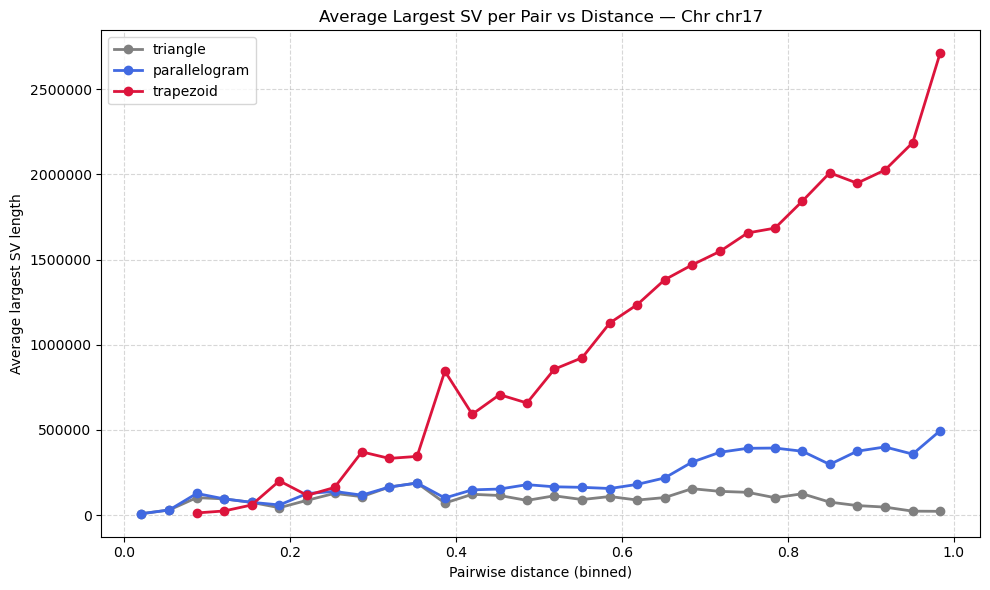

Processing chromosome: chr18


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


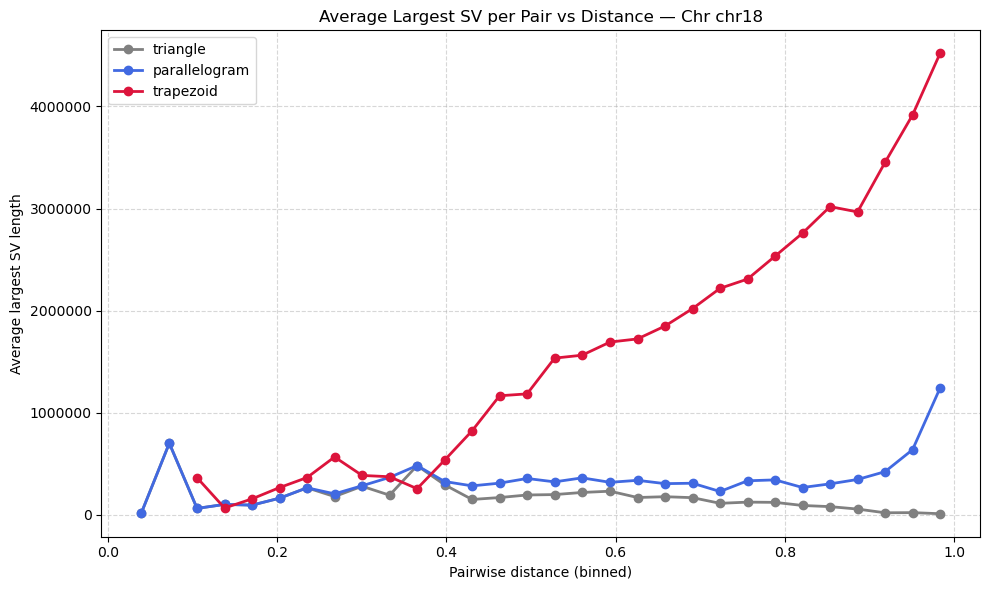

Processing chromosome: chr19


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


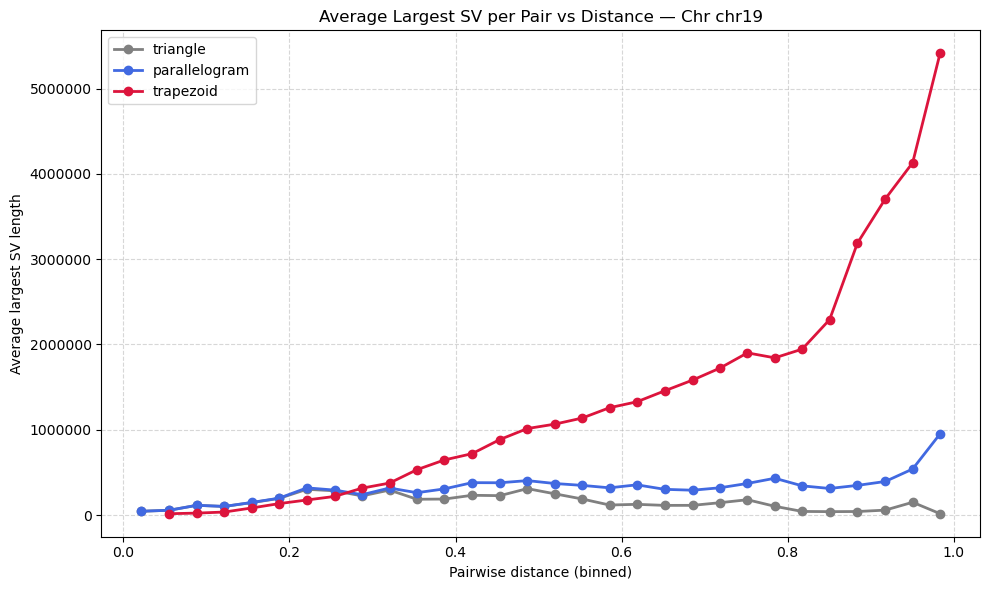

Processing chromosome: chr20


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


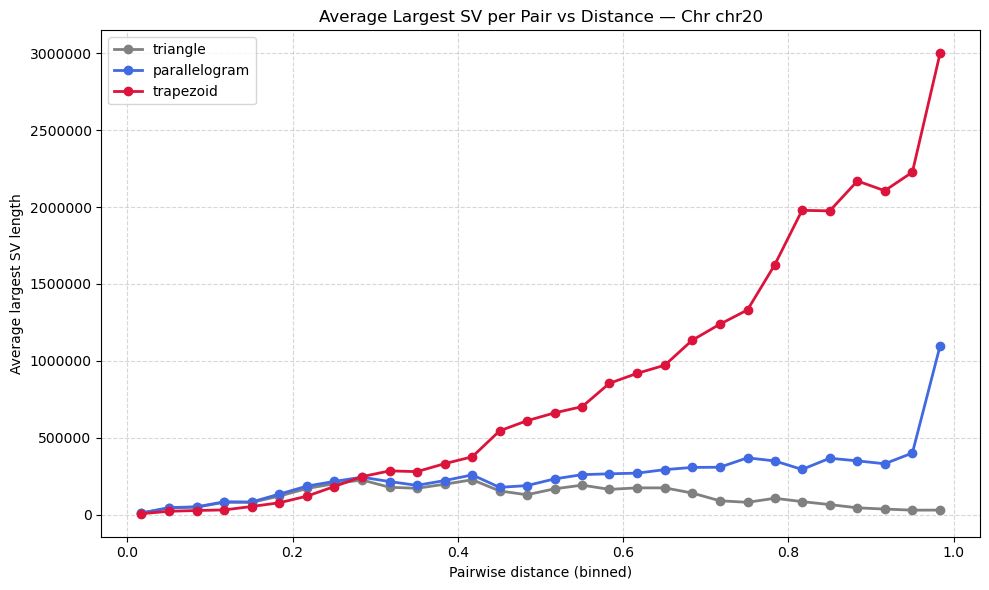

Processing chromosome: chr21


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


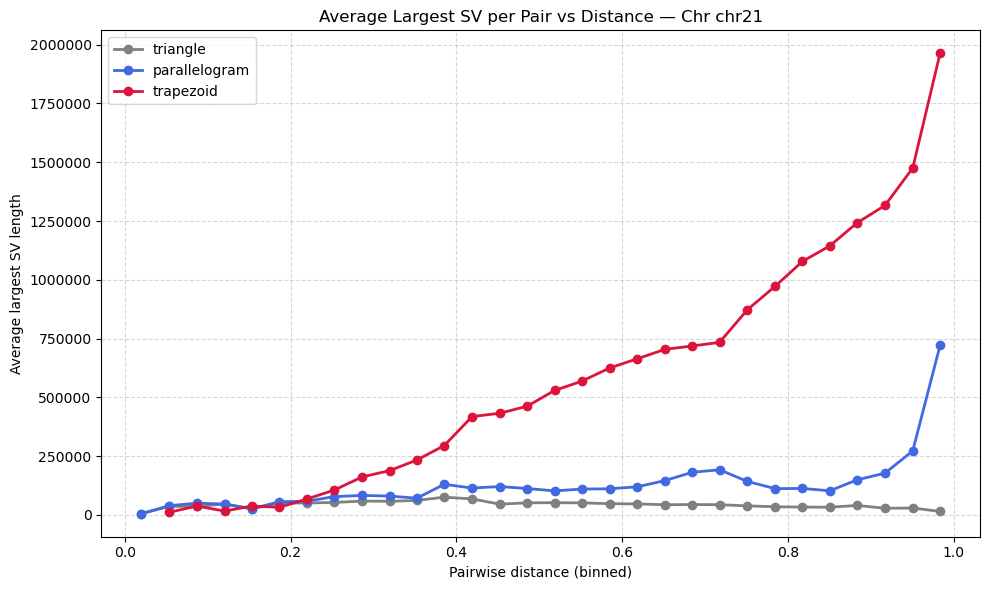

Processing chromosome: chr22


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


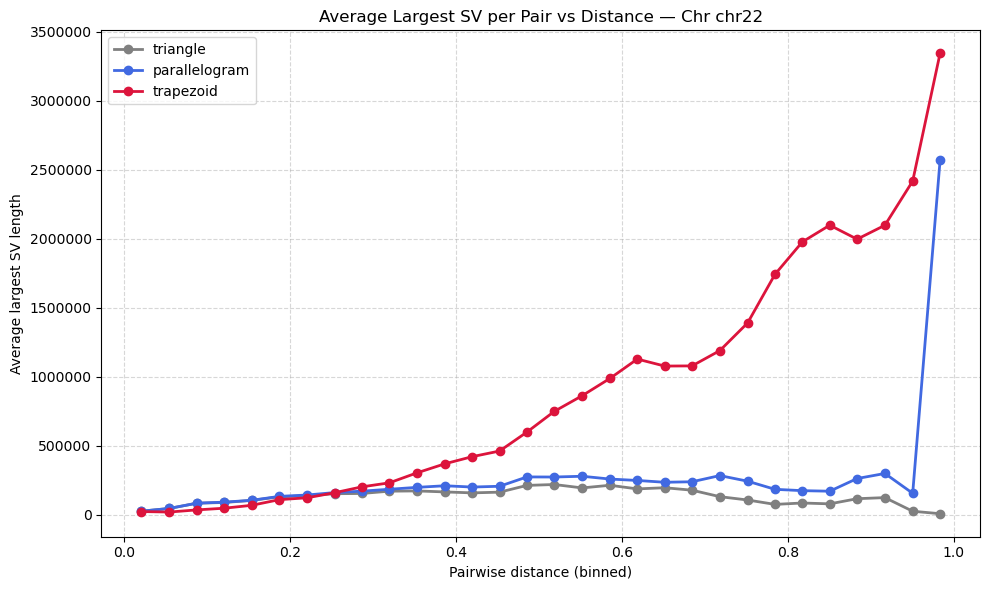

Processing chromosome: chr3


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


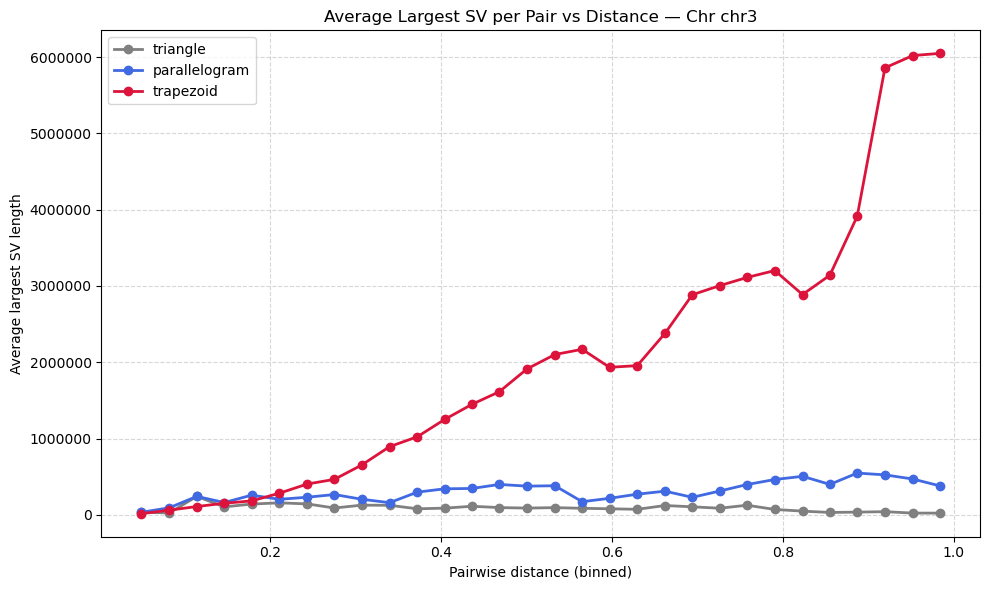

Processing chromosome: chr4


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


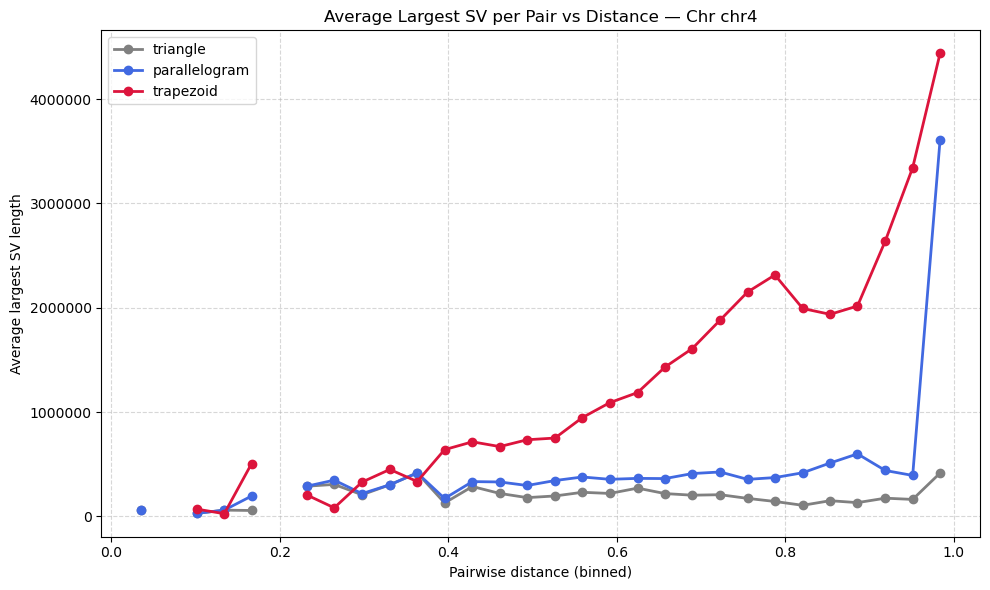

Processing chromosome: chr5


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


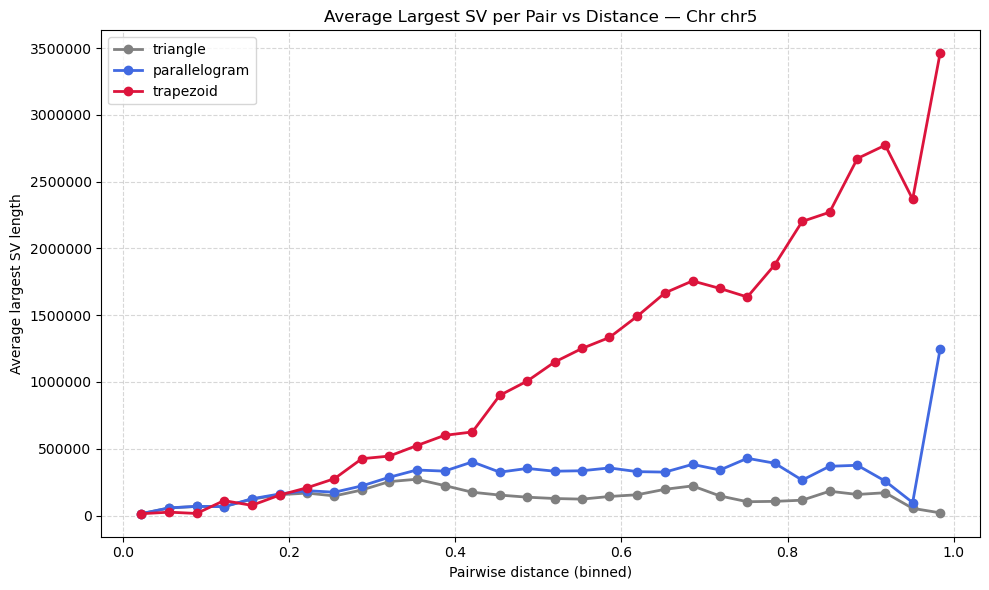

Processing chromosome: chr6


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


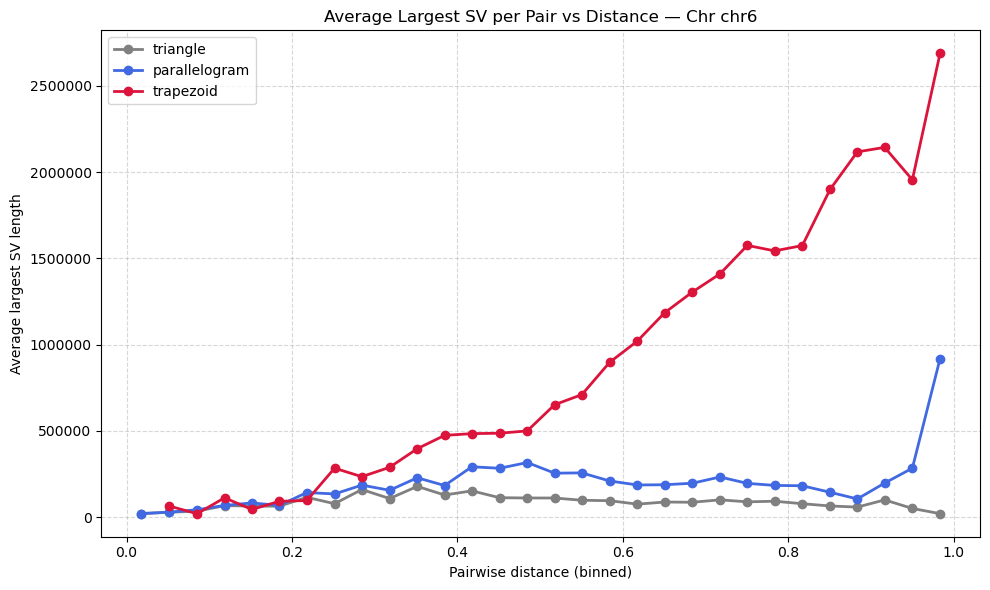

Processing chromosome: chr7


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


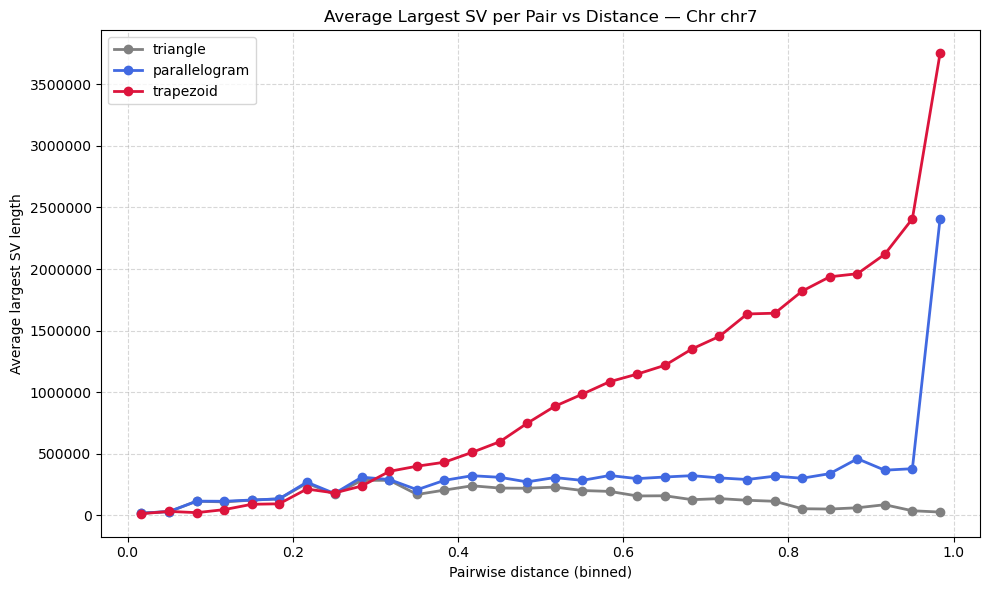

Processing chromosome: chr8


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


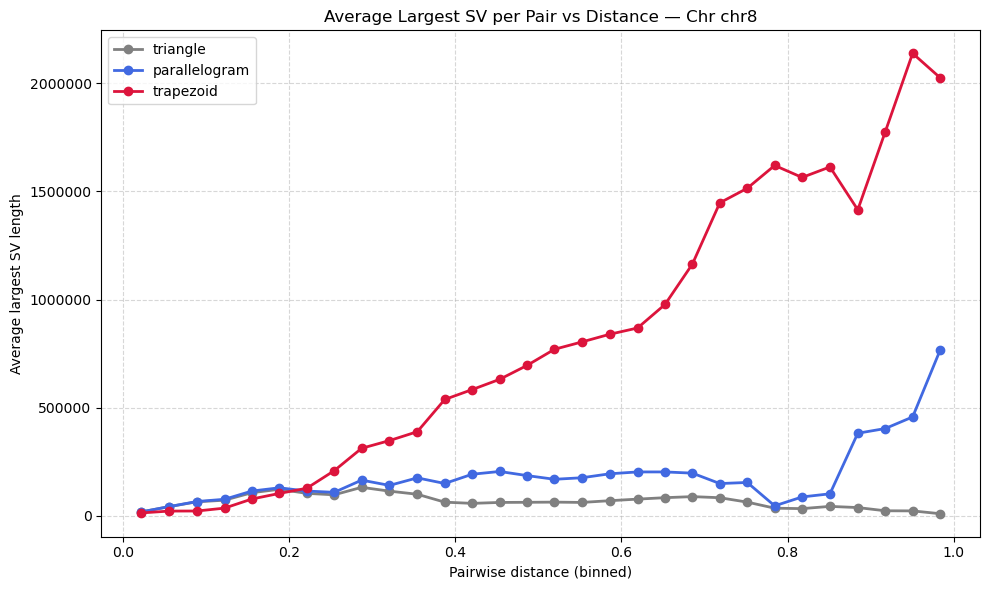

Processing chromosome: chr9


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


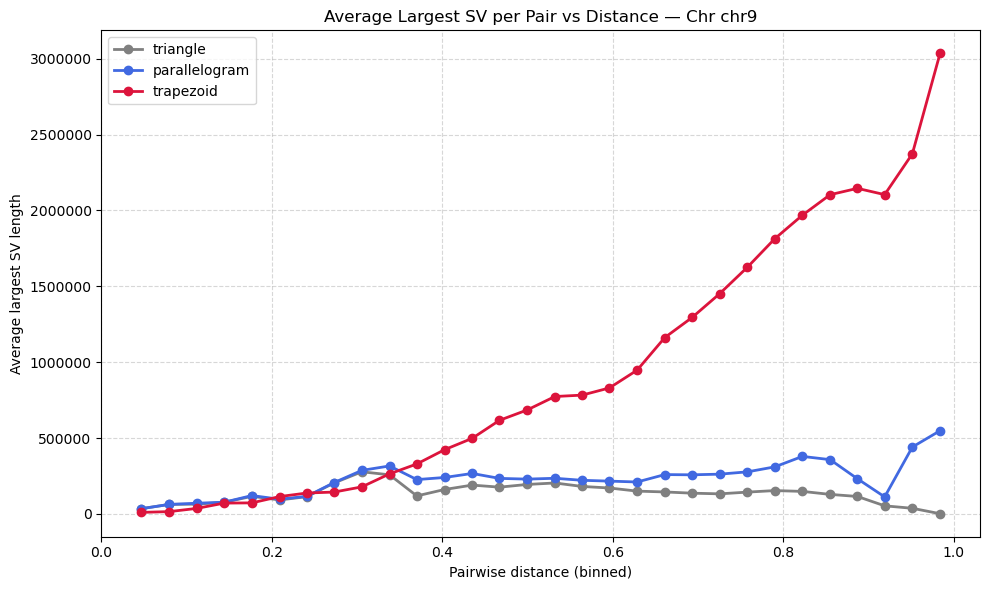

Processing chromosome: chrY


/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]
/data/tmp/ipykernel_2377993/816372722.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  largest.groupby("dist_bin")["length"]


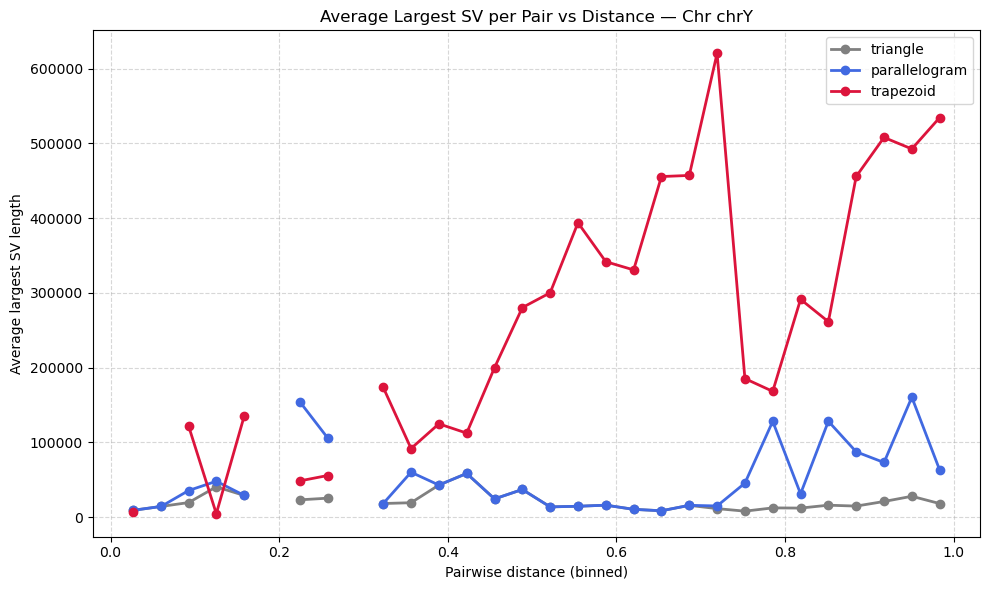

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Ensure sample_pair exists
df_sv_sorted["sample_pair"] = df_sv_sorted["sample1"] + "_" + df_sv_sorted["sample2"]

colors = {
    "triangle": "gray",
    "parallelogram": "royalblue",
    "trapezoid": "crimson"
}

# -------------------------------------------------------------------
# Function: largest SV per sample_pair
# -------------------------------------------------------------------
def get_largest_sv(subset):
    return (
        subset.sort_values("length", ascending=False)
              .groupby("sample_pair", as_index=False)
              .first()
    )   # keep the row containing the largest SV per sample_pair


# -------------------------------------------------------------------
# Loop over chromosomes
# -------------------------------------------------------------------
for chr_val in sorted(df_sv_sorted["chr"].unique()):

    print(f"Processing chromosome: {chr_val}")

    df_chr = df_sv_sorted[df_sv_sorted["chr"] == chr_val].copy()

    # convert distances
    df_chr["pairwise_dist"] = pd.to_numeric(df_chr["pairwise_dist"], errors="coerce")
    df_chr = df_chr.dropna(subset=["pairwise_dist"])

    # -------------------------------------------
    # define bins *per chromosome*
    # -------------------------------------------
    n_bins = 30
    df_chr["dist_bin"] = pd.cut(df_chr["pairwise_dist"], bins=n_bins)
    bin_categories = df_chr["dist_bin"].cat.categories

    # recreate masks but on df_chr
    conditions = {
        "triangle":      (df_chr["diff"] == -1),
        "parallelogram": (df_chr["diff"] < 0.1),
        "trapezoid":     (df_chr["diff"] > 0.1)
    }

    # -------------------------------------------
    # compute mean-largest-SV per bin per condition
    # -------------------------------------------
    plot_df = []

    for label, mask in conditions.items():
        subset = df_chr[mask].copy()

        # largest SV per sample pair
        largest = get_largest_sv(subset)

        # assign bins based on chromosome-specific edges
        largest["dist_bin"] = pd.cut(largest["pairwise_dist"], bins=bin_categories)

        stats = (
            largest.groupby("dist_bin")["length"]
                   .mean()
                   .reset_index(name="mean_length")
        )
        stats["condition"] = label
        plot_df.append(stats)

    plot_df = pd.concat(plot_df, ignore_index=True)

    # -------------------------------------------
    # Plot
    # -------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    for label in ["triangle", "parallelogram", "trapezoid"]:
        df_c = plot_df[plot_df["condition"] == label].copy()
        if df_c.empty:
            continue

        df_c["midpoint"] = df_c["dist_bin"].apply(lambda x: x.mid)

        ax.plot(
            df_c["midpoint"],
            df_c["mean_length"],
            marker="o",
            color=colors[label],
            linewidth=2,
            label=label
        )

    ax.set_xlabel("Pairwise distance (binned)")
    ax.set_ylabel("Average largest SV length")
    ax.set_title(f"Average Largest SV per Pair vs Distance — Chr {chr_val}")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

    yfmt = ScalarFormatter(useOffset=False)
    yfmt.set_scientific(False)
    ax.yaxis.set_major_formatter(yfmt)

    plt.tight_layout()
    plt.show()
